# Initialize Notebook

---

In [1]:
# Package imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the classes and helper functions from the PRIZM files
from src.PRIZM_classes import ZeroShotModellerModule, PlottingModule

In [2]:
# Initialize PRIZM
model_list = ['ESM1b','ESM1v','ESM2','Progen2','ProtGPT2','RITA','Tranception','Tranception_no_ret','UniRep', #Sequence
              'EVE','eUniRep','TranceptEVE', #MSA
              'ESM-IF1','ProteinMPNN'] #Structure
zsm_module = ZeroShotModellerModule('src/model_config.yaml') # Initialize the ZSM module
zsmplt = PlottingModule() # Initialize the plotting module

---

# Exploration - Low-N Dataset

In the Exploration phase of the PRIZM pipeline, the zero-shot scores of a Low-N dataset is compared to its experimental values. Importantly, this requires all the specified ZS predictors to have been run for the given dataset. The Exploration workflow will then be able to calculate the correlation metrics for every model and use these metrics to identify the best and worst overall models, as well as the best and worst models for each input category (Sequence, MSA, Structure).

## Load dataset

The data is loaded into the ZeroShotModeller (ZSM) module for future processing. Please specify datafile name and WT threshold, as well as the directory contained the ZS results.

---

In [3]:
# Change the values of the following variables as needed
lowN_name = 'FlA_HIM_RelAct'
wt_threshold = 80

In [4]:
zsm_module.set_threshold(lowN_name,wt_threshold)
zsm_module.load_scores(lowN_name,model_list)

---

## Process dataset

In this section, the correlation metrics are calculated, and the best/worst models are identified. Please not that the metrics used to identify the best/worst models are Spearman Correlation and Average Precision by default. If a different metric is desired, please see ZSM documentation for how to do this.

The Low-N dataset for FlA HIM is here used as an example



---

In [5]:
# Change the values of the following variables as needed
n_bootstrap = 1000 # Decrease to reduce computation time

In [6]:
zsm_module.compute_metrics(lowN_name,n_bootstrap=n_bootstrap, metrics = ['spearmanr', 'auc_roc','hit_rate','average_precision'])
zsm_module.process_models(lowN_name)

In [7]:
best_models = [zsm_module.best_models[lowN_name][cat] for cat in ['overall','sequence','MSA','structure']]
worst_models = [zsm_module.worst_models[lowN_name][cat] for cat in ['overall','sequence','MSA','structure']]
print('Best Overall Model:',best_models[0])
print('Best Sequence Model:',best_models[1])
print('Best MSA Model:',best_models[2])
print('Best Structure Model:',best_models[3])
print('---------------------------------')
print('Worst Overall Model:',worst_models[0])
print('Worst Sequence Model:',worst_models[1])
print('Worst MSA Model:',worst_models[2])
print('Worst Structure Model:',worst_models[3])

Best Overall Model: ESM-IF1
Best Sequence Model: ESM1b
Best MSA Model: TranceptEVE_M
Best Structure Model: ESM-IF1
---------------------------------
Worst Overall Model: UniRep
Worst Sequence Model: UniRep
Worst MSA Model: eUniRep
Worst Structure Model: ProteinMPNN


If needed, the scores of the best models can be saved in a file together with the raw DMS score

In [8]:
# Extract mutant information and DMS scores from experimental data
data_ = zsm_module.datasets[lowN_name]['exp_data'][['mutant','DMS_score']]

# Iterate through the best models and merge the predictions with the experimental data
for key,item in zsm_module.best_models[lowN_name].items():
    if key != 'overall': # Skip the overall model to avoid duplicate columns
        data_ = pd.merge(data_,zsm_module.datasets[lowN_name][item][['mutant',item]],on='mutant',how='inner')

# Save the data to a CSV file
data_.to_csv(f'../results/{lowN_name}_best_models_with_exp.csv',index=False)

---

## Plot results

In this section, correlation results are plotted. This includes a comparison of the performance of all models, as well as the performance of singular models. Again, please note that the default metrics are Spearman Correlation and Average Precision. See ZSM documentation for how to change this. Furthermore, please specify the folder for saving the metric figures.

---

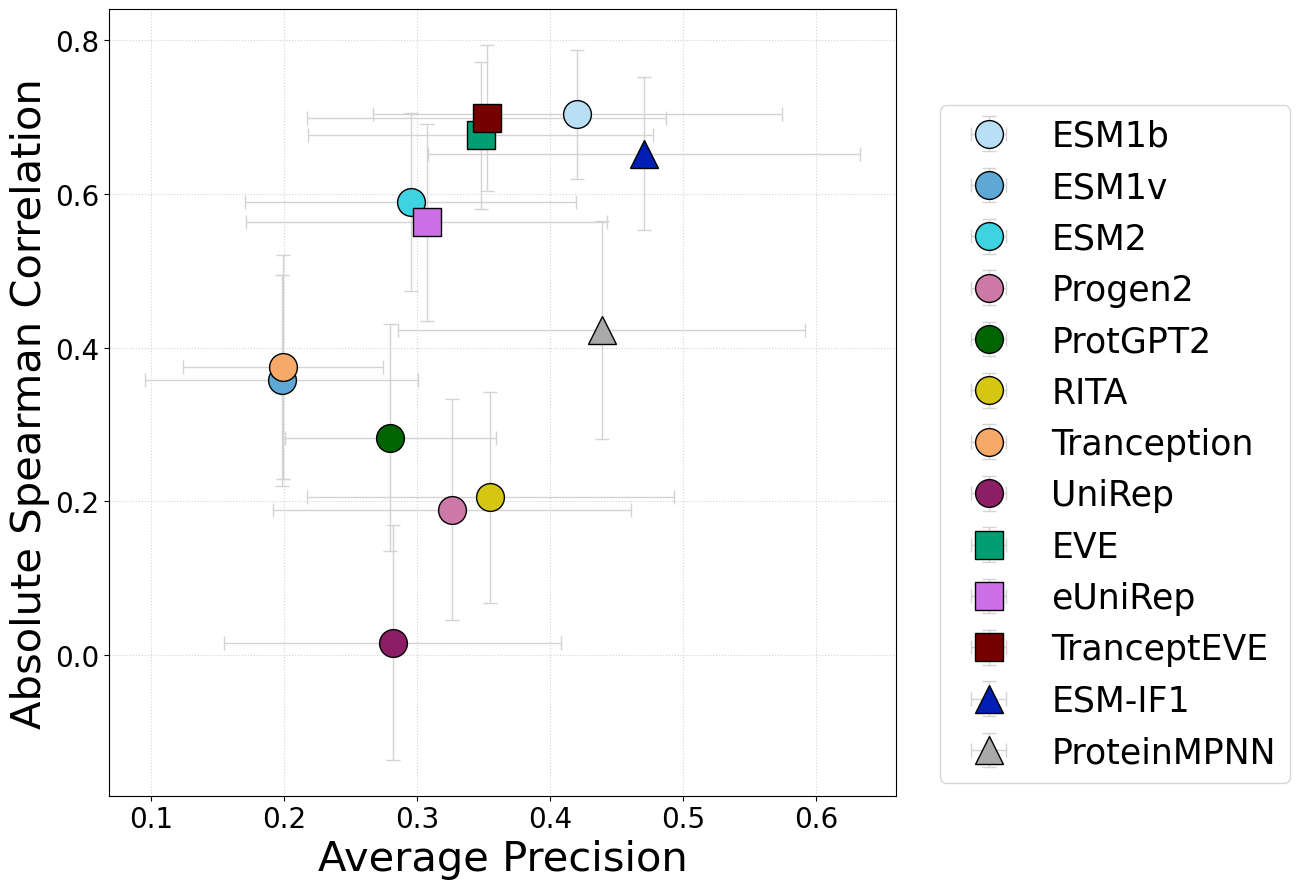

In [9]:
# Plotting the model performances
zsmplt.metrics(zsm_module, lowN_name)

In [10]:
# Plotting the model performances, with the best and worst models highlighted
zsmplt.metrics_cat(zsm_module, lowN_name)

In [11]:
zsmplt.metrics_cat(zsm_module, lowN_name, format='svg')

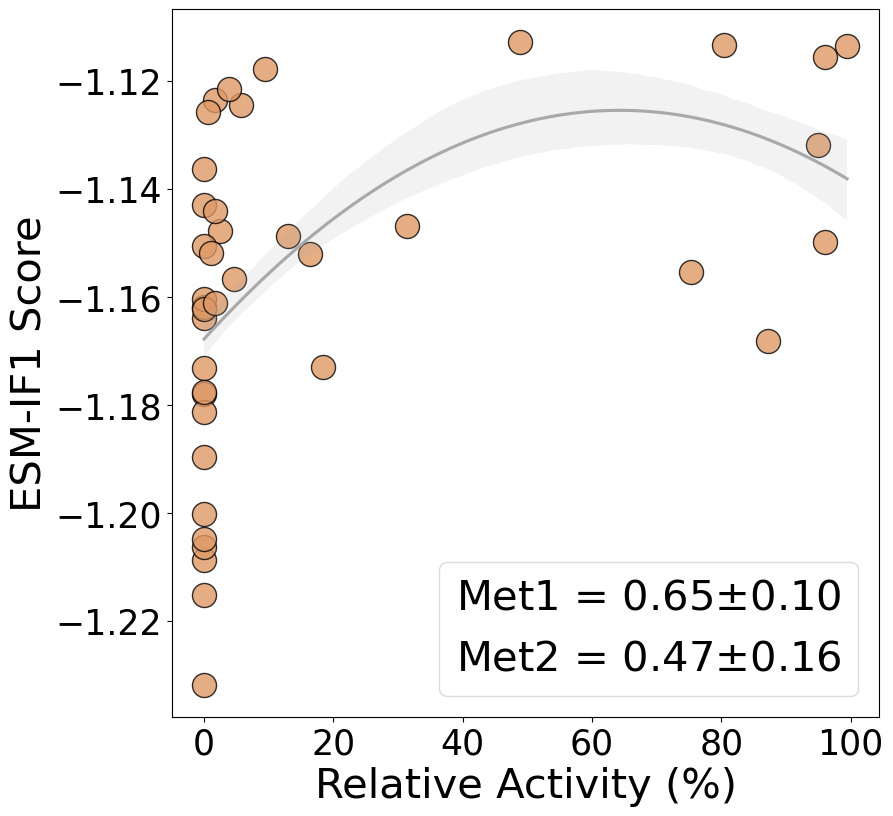

In [12]:
# Plotting the performance of the best model
# Met1 = Absolute Spearman correlation
# Met2 = Average Precision
model_name = 'ESM-IF1'
score_name = 'ESM-IF1'
exp_property = 'Relative Activity (%)'
zsmplt.zs_vs_exp_scatter(zsm_module,lowN_name,model_name,custom_zsname=score_name,custom_expname=exp_property, format='svg')

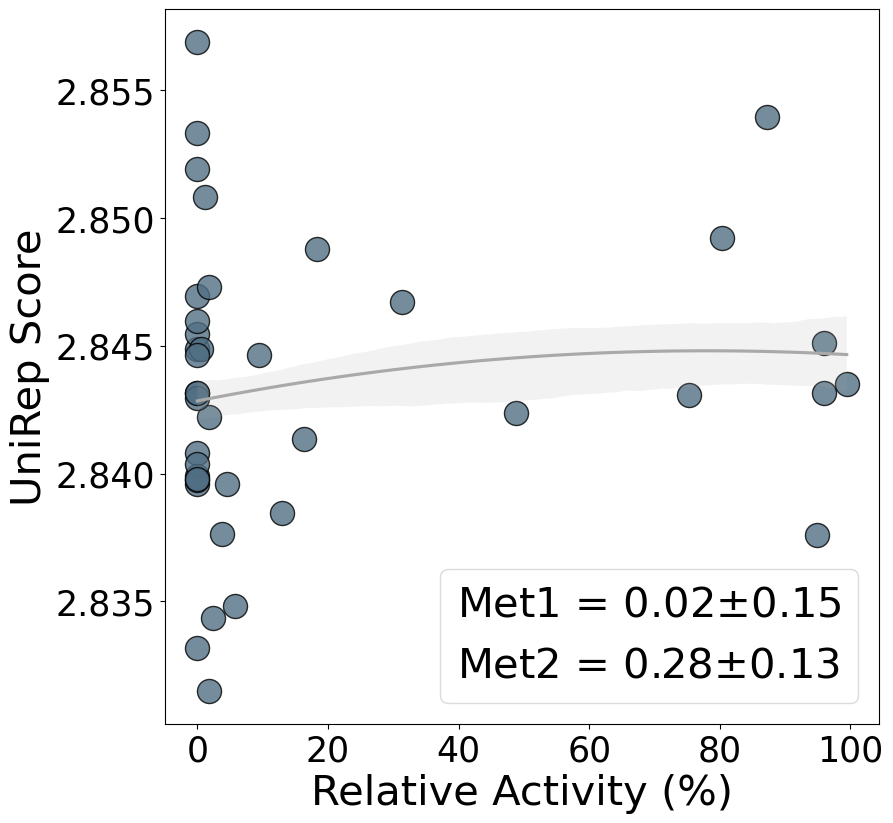

In [13]:
# Plotting the performance of the worst model
# Met1 = Absolute Spearman correlation
# Met2 = Average Precision
model_name = 'UniRep'
score_name = 'UniRep'
exp_property = 'Relative Activity (%)'
worst_color = '#516f84'
zsmplt.zs_vs_exp_scatter(zsm_module,lowN_name,model_name,custom_zsname=score_name,custom_expname=exp_property,color=worst_color, format='svg')

---

### Custom Plots

This section is for making custom plots, that is not suppported by the ZSM Class.

Below you can find plots that we used for the ZSM publication

---

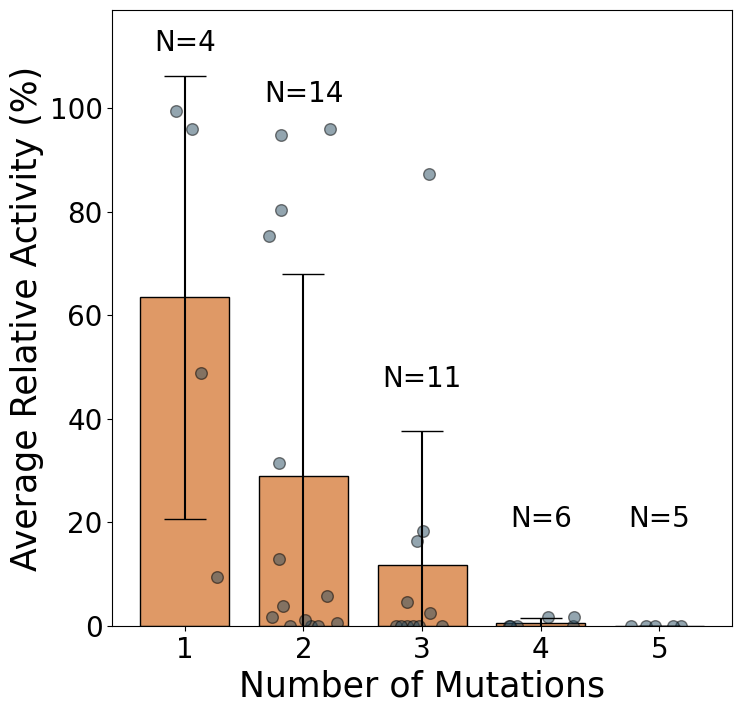

In [21]:
# Plotting the average DMS score for a specific number of mutations in a single variant

# Initialize the figure and parameters
fig, ax = plt.subplots(1,1,figsize=(8,8))
X = np.arange(1,6)
text_y = [110,100,45,18,18]

# Set the random seed for reproducibility
np.random.seed(42)

# Plot the average DMS score per number of mutations
ax.bar(X,[zsm_module.datasets[lowN_name]['exp_data'].DMS_score[zsm_module.datasets[lowN_name]['exp_data'].mutant.str.count(':')==i].mean() for i in np.arange(5)],
       yerr=[zsm_module.datasets[lowN_name]['exp_data'].DMS_score[zsm_module.datasets[lowN_name]['exp_data'].mutant.str.count(':')==i].std() for i in np.arange(5)],
       color='#DF9966',width=0.75,edgecolor='k',capsize=15)

# Plot the individual data points
for i in range(5):
    val = zsm_module.datasets[lowN_name]['exp_data'].DMS_score[zsm_module.datasets[lowN_name]['exp_data'].mutant.str.count(':')==i].values
    ax.scatter(X[i]+np.random.uniform(low=-0.3,high=0.3,size=len(val)),val,color='#294C60',edgecolor='k',s=70,alpha=0.5)
    
    # Annotate the number of data points
    ax.text(X[i],text_y[i],f'N={len(val)}',ha='center',va='bottom',fontsize=20)

# Set the label parameters and limits
ax.set_xlabel('Number of Mutations', fontsize=25)
ax.set_ylabel('Average Relative Activity (%)', fontsize=25)
ax.tick_params(labelsize=20)
ax.set_ylim(0,119)

# Save and display the plot
plt.savefig('../figures/DMS_score_vs_num_mutations.svg',dpi=300)
plt.show()

In [ ]:
# Load animo acid order and index from the PRIZM package and create color dictionary
from src.PRIZM_classes import aa_order, aa_to_index
count_colors_dict = {1: '#294C60', 2: '#0077CC', 3: '#ADB6C4', 4: '#F2D0A4', 5: '#DF9966'}

# Initialize a dictionary to store unique mutations by position
mutations_dict = {}

# Extract the mutant information
mutant_data = zsm_module.datasets[lowN_name]['exp_data'].mutant

# Iterate over all mutant information
for mutants in mutant_data:

    # Split by ":" to extract individual mutations
    mutations = mutants.split(":")

    # Iterate over all individual mutations
    for mutation in mutations:

        # Parse the mutation (e.g., E247G -> WT=E, Pos=247, Mut=G)
        match = re.match(r"([A-Z])(\d+)([A-Z])", mutation)

        # If the mutation is valid, store the mutant
        if match:
            wt, pos, mut = match.groups()

            # Initialize a list to store the mutations at each position if it does not exist
            if wt+pos not in mutations_dict:
                mutations_dict[wt+pos] = []
            
            # For every site, store the mutations that have been observed
            mutations_dict[wt+pos].append(mut)

# Extract the unique mutations and their indices, as well as the name of the sites
sites = list(mutations_dict.keys())
unique_mutations = [np.unique(mutations_dict[site]) for site in sites]
unique_mutations_idx = [[aa_to_index[m] for m in unique_mutations[i]] for i in range(len(unique_mutations))]

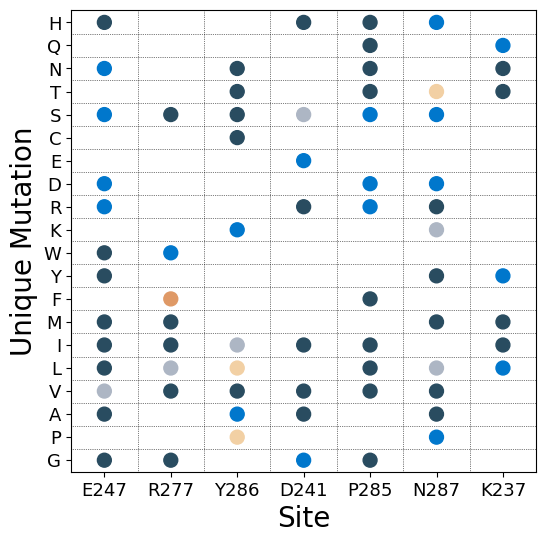

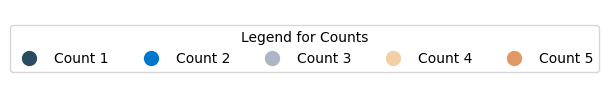

In [23]:
# Create a figure for showing number of unique mutations by site

# Initialize the figure and parameters
fig, ax = plt.subplots(1,1,figsize=(6,6))


# Iterate over all sites and plot the number of unique mutations
for s,site in enumerate(sites):

    # Count the number of occurrences of each unique mutation at a site
    count_mutations = [np.sum([mutations_dict[site][i]==M for i in range(len(mutations_dict[site]))]) for M in unique_mutations[s]]
    
    # Plot the unique mutations at a site and color them by the count
    ax.scatter([sites[s]]*len(unique_mutations[s]),unique_mutations_idx[s],c=[count_colors_dict[count] for count in count_mutations],s=100)

# Set the label parameters, grid lines, and limits
ax.set_xlabel('Site', fontsize=20)
ax.set_ylabel('Unique Mutation', fontsize=20)
ax.set_yticks(range(len(aa_order)))
ax.set_yticklabels(aa_order)
ax.tick_params(labelsize=13)
for i in range(len(aa_order)-1):
    ax.axhline(i+0.5, color='black', ls=':', lw=0.5)
for i in range(len(sites)-1):
    ax.axvline(i+0.5, color='black', ls=':', lw=0.5)
ax.set_xlim(-0.5,len(sites)-0.5)
ax.set_ylim(-0.5,len(aa_order)-0.45)

# Save and display the plot
plt.savefig('../figures//unique_mutations_by_site.svg',dpi=300)
plt.show()


# Create new figure for showing the legend
fig, ax = plt.subplots(figsize=(6, 1))

# Remove the axis and create a legend for the counts
ax.axis('off')
legend_handles = [
    plt.Line2D([0], [0], marker='o', color=color, label=f'Count {count}', 
               markersize=10, linestyle='None') 
    for count, color in count_colors_dict.items()
]

# Add the legend to the plot and display it
ax.legend(handles=legend_handles, loc='center', title="Legend for Counts", ncol=len(count_colors_dict))
plt.show()

---

# Exploitation - In-silico Library

After having identified the best models, we can use them to score the mutants of an in silico library. Again, this section assumes that the user has already obtaiend the ZS scores for the mutants of interest. If this hasn't been done, please run the "Make in-silico library" section and run the ZSM calculation pipeline for the best models.

## Make in-silico library

The code below demonstrates how to use the best models to score the mutants of an in silico library. The full single-mutant landscape for FlA HIM is here used as an example

---

In [5]:
# Change the values of the following variables as needed
dataset_name = 'FlA_HIM_RelAct'
library_suffix = 'SMscan'
numb_mut = [1] # For both single and double mutants, use the format [1,2]
wt_seq = 'MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHSMTPWDVEEGARYIVDLPRFFPEGTVFATTTYPATGTTTRSVAVRIRQAAKGGARGQWAGSGDGFERADGSYIYIAPNNGLLTTVLEEHGYIEAYEVTSTKVIPANPEPTFYSREMVAIPSAHLAAGFPLAEVGRRLDDSEIVRFHRPAVEISGEALSGVVTAIDHPFGNIWTNIHRTDLEKAGIGQGKHLKIILDDVLPFEAPLTPTFADAGAIGNIAFYLNSRGYLSLARNAASLAYPYNLKAGLKVRVEAR'

In [6]:
# Generate the insilico library
insilico_library = zsm_module.insilico_library(dataset_name,numb_mut,wt_seq=wt_seq,custom_name=library_suffix)

### Combitorial libraries

This section is for creating combinatorial libraries of the sites having shown higher relative activity than the WT

In [8]:
# Double mutants
library_suffix = 'DM_combi'
numb_mut = [2] # For both single and double mutants, use the format [1,2]
mut_sites = [298,297,3,299,2,5,32,285,191,37,166,235,239,234]
insilico_library = zsm_module.insilico_library(dataset_name,numb_mut,wt_seq=wt_seq,custom_name=library_suffix,mut_sites=mut_sites)

---

## Single-points Mutants

### Load dataset

The in silico library ZS scores for the best models identied in the Exploration phase is loaded. The same wildtype threshold is used as in the previous phase

---

In [26]:
# Change the values of the following variables as needed
dataset_name = 'FlA_HIM_RelAct'
library_suffix = 'SMscan'
model_list_selection = ['ESM1b','TranceptEVE','ESM-IF1'] # Best models from each category
library_name = dataset_name+'_'+library_suffix+'_insilico_library'

In [27]:
zsm_module.set_threshold(library_name,wt_threshold)
zsm_module.load_scores(library_name,model_list_selection,wt=True)

---

### Sort and Rank library

In this section, the in silico libraries are sorted and ranked based on the best models obtained from the Exploration phase. This can be used to identify mutants for experimental validation.

It should be noted that the order of the ranking is based on maximizing the Spearman Correlation. Please see PRIZM documentation for how to change this


---

In [19]:
# Define the best models from each category and the overall best model
best_models = [zsm_module.best_models[lowN_name][cat] for cat in ['sequence','MSA','structure']] # Best models from each category
best_overall = zsm_module.best_models[lowN_name]['overall'] # Best overall model, used for final sorting

In [31]:
library_ranking = zsm_module.sorting_mutants(library_name,best_models,best_overall,'../results/',wt=True)

In [26]:
# Top 10 mutants for best model (ESM-IF1, which is a structure-based model)
library_ranking.head(10)

mutant                                   mutated_sequence   WT  Mut  \
1234   F65V  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [F]  [V]   
1225   F65I  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [F]  [I]   
3600  F190I  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [F]  [I]   
3601  F190L  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [F]  [L]   
2990  S158G  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [S]  [G]   
687    G37D  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPDVTVVDVCHS...  [G]  [D]   
1226   F65L  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [F]  [L]   
1443   T76V  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [T]  [V]   
3609  F190V  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [F]  [V]   
3135  S166A  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [S]  [A]   

        Pos     ESM1b  ESM1b_rank  ESM1b_bin  TranceptEVE  TranceptEVE_rank  \
1234   [65] -3.712790      1103.0          0    -0.008637            2650.0   
1225   [65] -4.391283      1735.0          0    -0.011007            3579.0   
3600  [190] -3.571116      1001.0          0    -0.002754             642.0   
3601  [190] -1.703775       174.0          0    -0.002258             520.0   
2990  [158] -1.129083        98.0          0    -0.000222             225.0   
687    [37] -2.017996       238.0          0     0.003287              41.0   
1226   [65] -3.430337       903.0          0    -0.007093            1972.0   
1443   [76]  0.272748        16.0          1    -0.000128             215.0   
3609  [190] -4.235110      1562.0          0    -0.005176            1302.0   
3135  [166] -0.073914        28.0          0     0.002535              57.0   

      TranceptEVE_bin   ESM-IF1  ESM-IF1_rank  ESM-IF1_bin  
1234                0 -1.073169           1.0            1  
1225                0 -1.075488           2.0            1  
3600                0 -1.077220           3.0            1  
3601                0 -1.078463           4.0            1  
2990                0 -1.081796           5.0            1  
687                 1 -1.083609           6.0            1  
1226                0 -1.083951           7.0            1  
1443                0 -1.084091           8.0            1  
3609                0 -1.084098           9.0            1  
3135                1 -1.084167          10.0            1

In [27]:
# Top 10 mutants for best sequence-based model
library_ranking.sort_values('ESM1b',ascending=False).head(10)

mutant                                   mutated_sequence   WT  Mut  \
1447   Y77D  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [D]   
1446   Y77N  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [N]   
3118  P165N  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [P]  [N]   
1449   Y77E  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [E]   
1452   Y77H  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [H]   
1459   Y77S  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [S]   
3116  P165A  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [P]  [A]   
1444   Y77A  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [A]   
3131  P165T  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [P]  [T]   
1945  W103G  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [W]  [G]   

        Pos     ESM1b  ESM1b_rank  ESM1b_bin  TranceptEVE  TranceptEVE_rank  \
1447   [77]  4.879274         1.0          1    -0.000926             300.0   
1446   [77]  2.179950         2.0          1    -0.004744            1165.0   
3118  [165]  1.768451         3.0          1    -0.006341            1686.0   
1449   [77]  1.650586         4.0          1    -0.007267            2057.0   
1452   [77]  1.452774         5.0          1    -0.008312            2493.0   
1459   [77]  1.170858         6.0          1    -0.007963            2352.5   
3116  [165]  1.000628         7.0          1    -0.001771             417.0   
1444   [77]  0.765227         8.0          1    -0.008316            2495.0   
3131  [165]  0.697421         9.0          1    -0.003673             885.0   
1945  [103]  0.555774        10.0          1    -0.005662            1451.0   

      TranceptEVE_bin   ESM-IF1  ESM-IF1_rank  ESM-IF1_bin  
1447                0 -1.102735         807.0            0  
1446                0 -1.110766        1733.0            0  
3118                0 -1.158603        5474.0            0  
1449                0 -1.112273        1899.0            0  
1452                0 -1.108492        1453.0            0  
1459                0 -1.117465        2510.0            0  
3116                0 -1.139212        4465.0            0  
1444                0 -1.117769        2544.0            0  
3131                0 -1.137935        4369.0            0  
1945                0 -1.095991         249.0            1

In [28]:
# Top 10 mutants for best MSA-based model
library_ranking.sort_values('TranceptEVE',ascending=False).head(10)

mutant                                   mutated_sequence   WT  Mut  \
5656  A298P  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [A]  [P]   
5639  E297T  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [E]  [T]   
38      A3R  MARNGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [A]  [R]   
5670  R299I  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [R]  [I]   
24      A2Q  MQANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [A]  [Q]   
77      G5R  MAANRSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [G]  [R]   
598    H32L  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMLSICPGVTVVDVCHS...  [H]  [L]   
2039  D108G  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [D]  [G]   
5016  F265A  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [F]  [A]   
4991  I263P  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [I]  [P]   

        Pos     ESM1b  ESM1b_rank  ESM1b_bin  TranceptEVE  TranceptEVE_rank  \
5656  [298] -4.323143      1668.0          0     0.012430               1.0   
5639  [297] -5.534917      2705.0          0     0.012378               2.0   
38      [3] -4.041022      1380.0          0     0.012109               3.0   
5670  [299] -4.213018      1544.0          0     0.011582               4.0   
24      [2] -4.902130      2165.0          0     0.011392               5.0   
77      [5] -3.424495       898.0          0     0.008444               6.0   
598    [32] -1.701840       172.0          0     0.008257               7.0   
2039  [108] -2.777985       517.0          0     0.007663               8.0   
5016  [265] -0.642537        65.0          0     0.007453               9.0   
4991  [263] -2.864151       552.0          0     0.005773              10.0   

      TranceptEVE_bin   ESM-IF1  ESM-IF1_rank  ESM-IF1_bin  
5656                1 -1.130454        3769.0            0  
5639                1 -1.113203        2004.0            0  
38                  1 -1.095150         205.0            1  
5670                1 -1.102181         751.0            0  
24                  1 -1.102386         770.0            0  
77                  1 -1.093404         136.0            1  
598                 1 -1.090890          72.0            1  
2039                1 -1.099866         539.0            0  
5016                1 -1.117605        2520.0            0  
4991                1 -1.125818        3336.0            0

---

The binary results can be used to identify mutants where more than one ZS predictor predicts it to be above wildtype.

It should be noted that for the given example (FlA HIM single-mutant landscape), not mutant are predicted to be above wildtype for all three models.

---

In [ ]:
# Constructing binary masks for variants with predicted values above the WT
ESM_IF1_mask = library_ranking['ESM-IF1_bin'] == 1
ESM1b_mask = library_ranking['ESM1b_bin'] == 1
TranceptEVE_mask = library_ranking['TranceptEVE_bin'] == 1

In [30]:
# Mutant where all three models predict it to be better than the wildtype
FlA_ranking_filtered = library_ranking[ESM_IF1_mask & ESM1b_mask & TranceptEVE_mask]
FlA_ranking_filtered

Empty DataFrame
Columns: [mutant, mutated_sequence, WT, Mut, Pos, ESM1b, ESM1b_rank, ESM1b_bin, TranceptEVE, TranceptEVE_rank, TranceptEVE_bin, ESM-IF1, ESM-IF1_rank, ESM-IF1_bin]
Index: []

In [31]:
# Mutant where ESM-IF1 and ESM1b predict it to be better than the wildtype
FlA_ranking_filtered = library_ranking[ESM_IF1_mask & ESM1b_mask]
FlA_ranking_filtered

mutant                                   mutated_sequence   WT  Mut  \
1443   T76V  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [T]  [V]   
1945  W103G  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [W]  [G]   

        Pos     ESM1b  ESM1b_rank  ESM1b_bin  TranceptEVE  TranceptEVE_rank  \
1443   [76]  0.272748        16.0          1    -0.000128             215.0   
1945  [103]  0.555774        10.0          1    -0.005662            1451.0   

      TranceptEVE_bin   ESM-IF1  ESM-IF1_rank  ESM-IF1_bin  
1443                0 -1.084091           8.0            1  
1945                0 -1.095991         249.0            1

In [32]:
# Mutant where ESM-IF1 and TranceptEVE predict it to be better than the wildtype
FlA_ranking_filtered = library_ranking[ESM1b_mask & TranceptEVE_mask]
FlA_ranking_filtered

mutant                                   mutated_sequence   WT  Mut  \
5382  Y284E  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [E]   
4963  N262E  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [N]  [E]   
5377  Y284A  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [A]   
5388  Y284K  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [Y]  [K]   
5397  P285R  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [P]  [R]   

        Pos     ESM1b  ESM1b_rank  ESM1b_bin  TranceptEVE  TranceptEVE_rank  \
5382  [284]  0.164408        19.0          1     0.002095              69.0   
4963  [262]  0.364636        14.0          1     0.004591              24.0   
5377  [284]  0.483088        11.0          1     0.001367              97.0   
5388  [284]  0.045624        24.0          1     0.000070             188.0   
5397  [285]  0.233732        18.0          1     0.001376              96.0   

      TranceptEVE_bin   ESM-IF1  ESM-IF1_rank  ESM-IF1_bin  
5382                1 -1.098699         429.0            0  
4963                1 -1.103888         918.0            0  
5377                1 -1.104199         953.0            0  
5388                1 -1.106279        1208.0            0  
5397                1 -1.116667        2400.0            0

In [33]:
# Mutants where ESM-IF1 and TranceptEVE predict it to be better than the wildtype. Only the top 2 are shown, sorted by ESM1b score.
FlA_ranking_filtered = library_ranking[ESM_IF1_mask & TranceptEVE_mask]
FlA_ranking_filtered.sort_values('ESM1b',ascending=False).head(2)

mutant                                   mutated_sequence   WT  Mut  \
3135  S166A  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [S]  [A]   
316    L17F  MAANGSQRPIIAFMSDFGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [L]  [F]   

        Pos     ESM1b  ESM1b_rank  ESM1b_bin  TranceptEVE  TranceptEVE_rank  \
3135  [166] -0.073914        28.0          0     0.002535              57.0   
316    [17] -0.524117        51.0          0     0.000158             181.0   

      TranceptEVE_bin   ESM-IF1  ESM-IF1_rank  ESM-IF1_bin  
3135                1 -1.084167          10.0            1  
316                 1 -1.090612          66.0            1

In [34]:
# Mutant where ESM-IF1 and TranceptEVE predict it to be better than the wildtype. The list is sorted by the combined rank of the two models, with the top 6 shown.
FlA_ranking_filtered = library_ranking[ESM_IF1_mask & TranceptEVE_mask]
FlA_ranking_filtered = FlA_ranking_filtered.copy()
FlA_ranking_filtered['Combined_rank'] = FlA_ranking_filtered['ESM-IF1_rank'] + FlA_ranking_filtered['TranceptEVE_rank']
FlA_ranking_filtered.sort_values('Combined_rank').head(6)

mutant                                   mutated_sequence   WT  Mut  \
3615  H191E  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [H]  [E]   
687    G37D  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPDVTVVDVCHS...  [G]  [D]   
3135  S166A  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [S]  [A]   
3613  H191D  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [H]  [D]   
598    H32L  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMLSICPGVTVVDVCHS...  [H]  [L]   
4447  H235R  MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...  [H]  [R]   

        Pos     ESM1b  ESM1b_rank  ESM1b_bin  TranceptEVE  TranceptEVE_rank  \
3615  [191] -1.676473       165.0          0     0.004273              30.0   
687    [37] -2.017996       238.0          0     0.003287              41.0   
3135  [166] -0.073914        28.0          0     0.002535              57.0   
3613  [191] -1.452164       134.0          0     0.005451              15.0   
598    [32] -1.701840       172.0          0     0.008257               7.0   
4447  [235] -1.266629       110.0          0     0.005764              11.0   

      TranceptEVE_bin   ESM-IF1  ESM-IF1_rank  ESM-IF1_bin  Combined_rank  
3615                1 -1.086629          16.0            1           46.0  
687                 1 -1.083609           6.0            1           47.0  
3135                1 -1.084167          10.0            1           67.0  
3613                1 -1.090310          57.0            1           72.0  
598                 1 -1.090890          72.0            1           79.0  
4447                1 -1.091095          79.0            1           90.0

---

### Plotting model predictions

Using PRIZM, the user is able to plot and compare the predictions of three different models.

Any catalytic residues and positions of interest can also be highlighted to examine their patterns. As an example, the original mutational sites (interface positions) are plotted for the FlA HIM

---

In [34]:
# Change the values of the following variables as needed
model_1 = 'ESM1b'
model_2 = 'TranceptEVE_M'
model_3 = 'ESM-IF1'
model_labels = ['ESM1b (Sequence)','TranceptEVE (MSA)','ESM-IF1 (Structure)']

pos_catalytic = [16, 50, 158, 215]
pos_interest = [237, 241, 277, 247, 285, 286, 287]

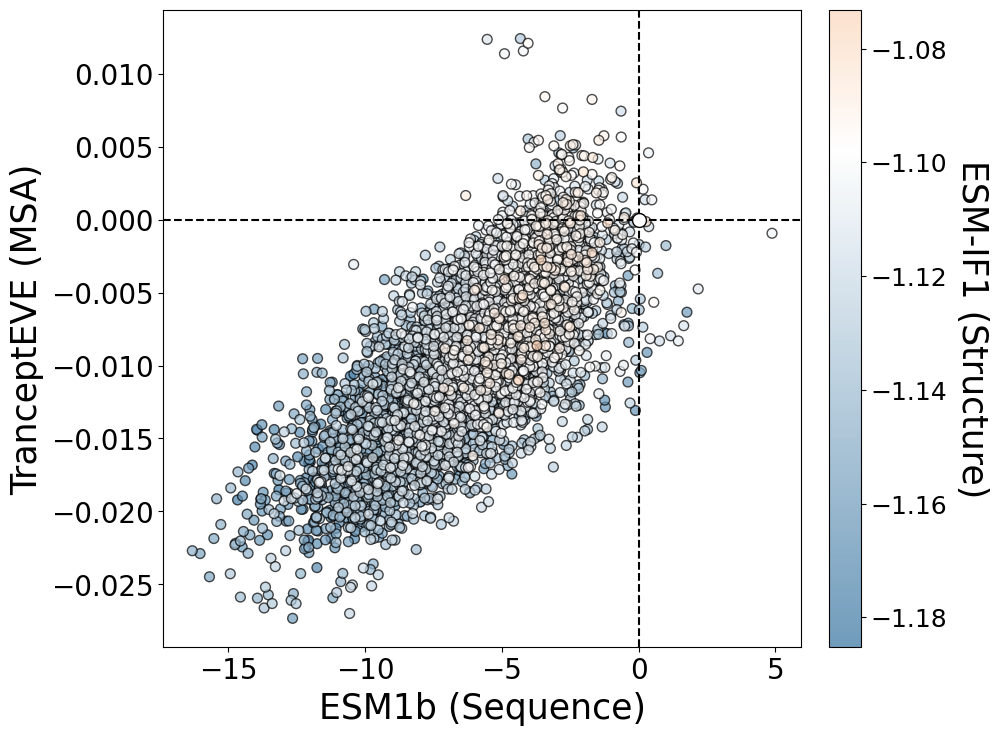

In [36]:
zsmplt.best_models_scatter(zsm_module, library_name, [model_1,model_2,model_3], labels=model_labels,
                           colors = ['#34729F', 'white', '#F36906'],alpha=0.7, format='svg')

In [37]:
zsmplt.best_models_scatter(zsm_module, library_name, [model_1,model_2,model_3], labels=model_labels,
                           pos_catalytic=pos_catalytic, pos_interest=pos_interest,
                           colors = ['#34729F', 'white', '#F36906'],alpha=0.7, format='svg')

---

### Single-Mutant Landscapes

ZeroShotModeller enables the user to generate and plot the full single-mutant landscape for a given model.

Again, FlA HIM is used as an example, with the best models identified in the Exploration phase (ESM-IF1, ESM1b, and TranceptEVE) being used to generate the landscapes.

---

In [38]:
# Change the values of the following variables as needed
landscape_rows = 3

In [39]:
# Generating the SM landscapes for the three models
for model in best_models:
    zsm_module.sm_landscape(library_name,model,wt=True)

In [40]:
zsmplt.heatmap(zsm_module, library_name, 'ESM-IF1', landscape_rows, 'ESM-IF1 Score',alpha=1,
               colors=['#34729F', 'white', '#F36906'], format='svg',figsize=(50, 30))

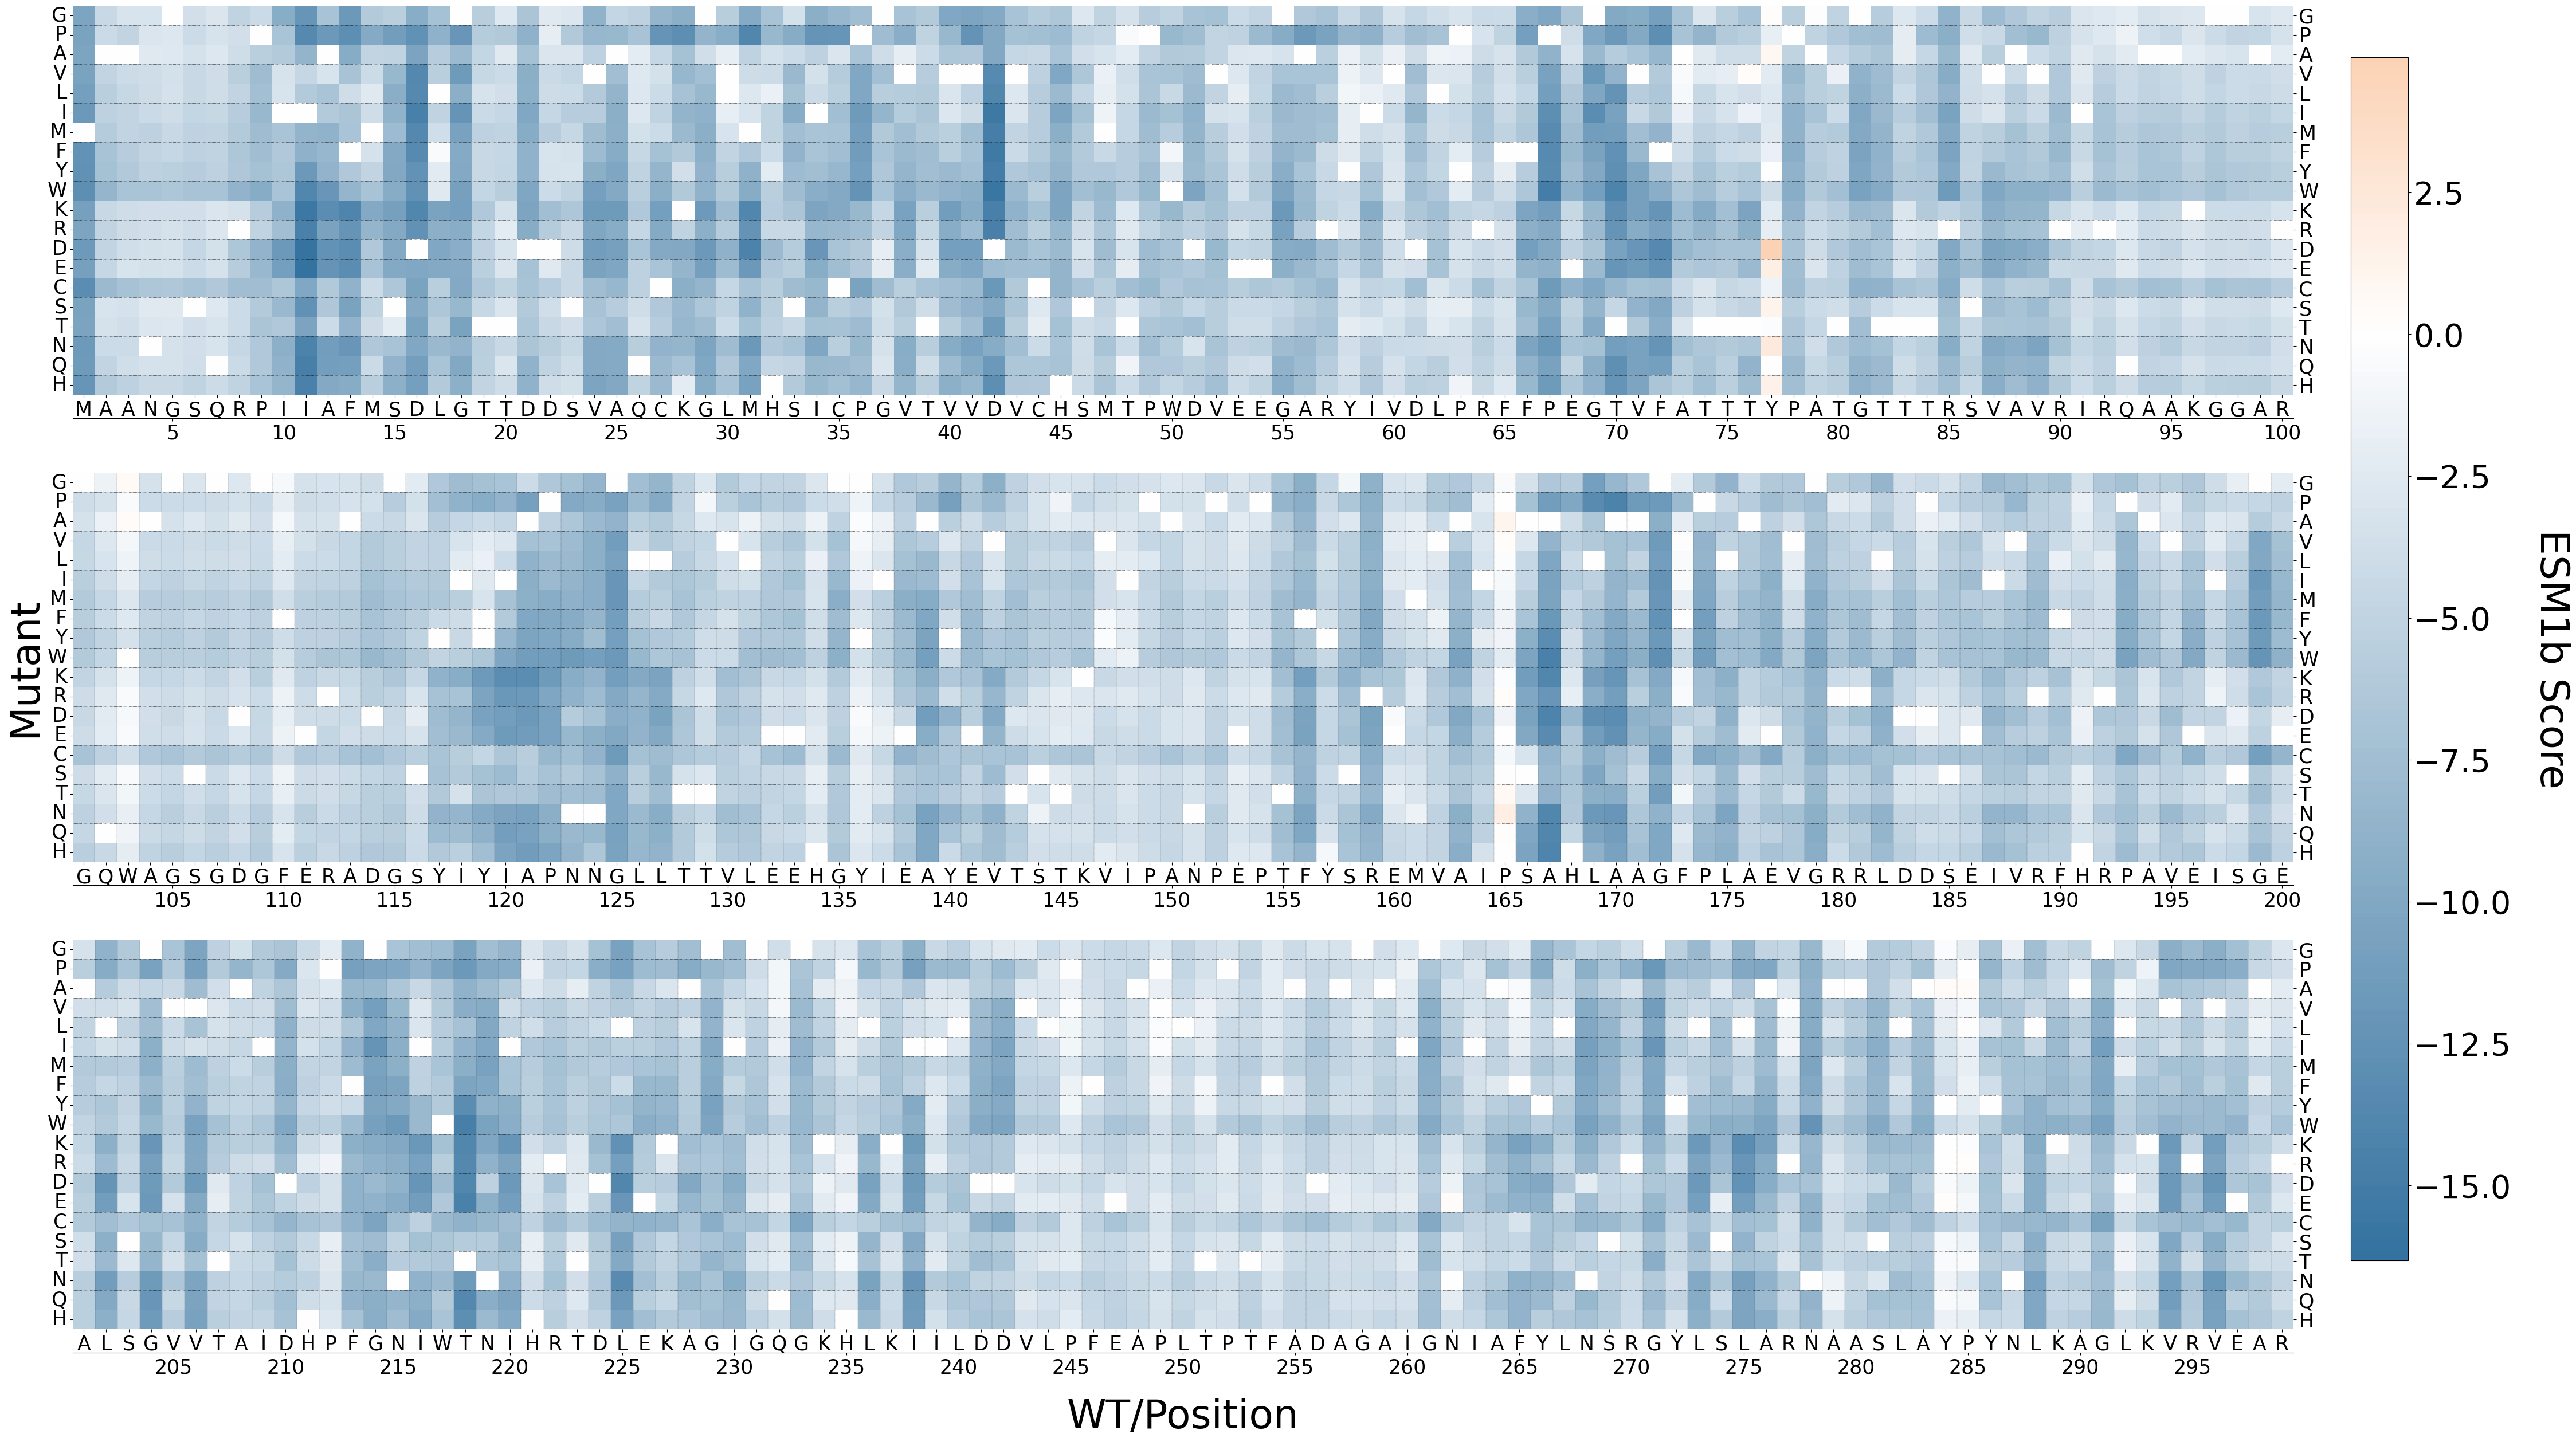

In [41]:
zsmplt.heatmap(zsm_module, library_name, 'ESM1b', landscape_rows, 'ESM1b Score', alpha=1,colors=['#34729F', 'white', '#F36906'],figsize=(50, 30))

In [42]:
zsmplt.heatmap(zsm_module, library_name, 'TranceptEVE_M', landscape_rows, 'TranceptEVE Score', alpha=1,colors=['#34729F', 'white', '#F36906'],figsize=(50, 30))

-----

## Double Mutants

### Load dataset

The in silico library ZS scores for the best models identied in the Exploration phase is loaded. The same wildtype threshold is used as in the previous phase

-----

In [16]:
# Change the values of the following variables as needed
dataset_name = 'FlA_HIM_RelAct'
library_suffix = 'DM_combi'
model_list_selection = ['ESM1b','TranceptEVE','ESM-IF1'] # Best models from each category
library_name = dataset_name+'_'+library_suffix+'_insilico_library'

In [17]:
zsm_module.set_threshold(library_name,wt_threshold)
zsm_module.load_scores(library_name,model_list_selection,wt=True)

------

### Sort and Rank library

In this section, the in silico libraries are sorted and ranked based on the best models obtained from the Exploration phase. This can be used to identify mutants for experimental validation.

It should be noted that the order of the ranking is based on maximizing the Spearman Correlation. Please see PRIZM documentation for how to change this

-----

In [18]:
# Define the best models from each category and the overall best model
best_models = [zsm_module.best_models[lowN_name][cat] for cat in ['sequence','MSA','structure']] # Best models from each category
best_overall = zsm_module.best_models[lowN_name]['overall'] # Best overall model, used for final sorting

In [21]:
library_ranking = zsm_module.sorting_mutants(library_name,best_models,best_overall,'../results/',wt=True)

-----------

### Plot Predictions

----

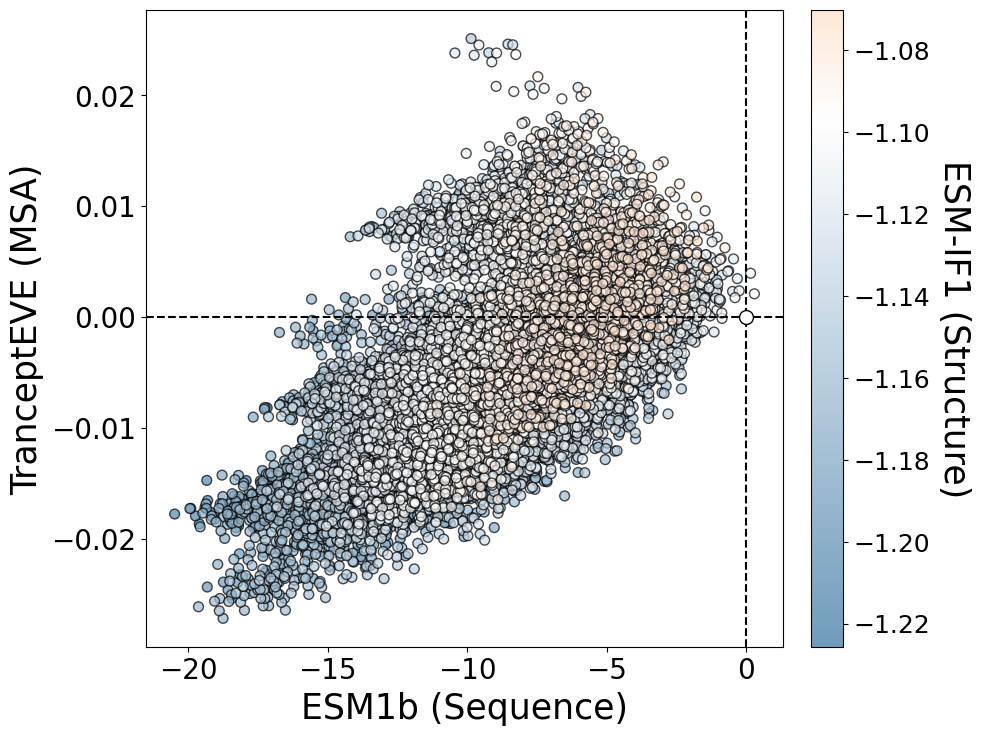

In [24]:
# Change the values of the following variables as needed
model_1 = 'ESM1b'
model_2 = 'TranceptEVE_M'
model_3 = 'ESM-IF1'
model_labels = ['ESM1b (Sequence)','TranceptEVE (MSA)','ESM-IF1 (Structure)']

zsmplt.best_models_scatter(zsm_module, library_name, [model_1, model_2, model_3], labels=model_labels,
                           colors = ['#34729F', 'white', '#F36906'],alpha=0.7, format='svg')

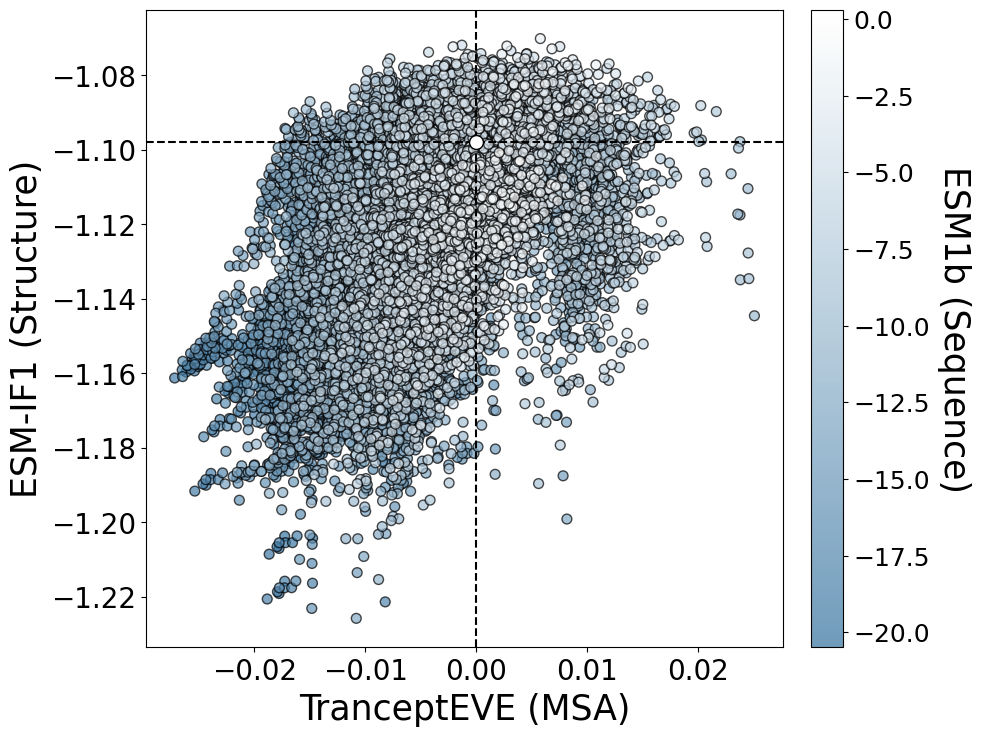

In [26]:
# Change the values of the following variables as needed
model_1 = 'TranceptEVE_M'
model_2 = 'ESM-IF1'
model_3 = 'ESM1b'
model_labels = ['TranceptEVE (MSA)','ESM-IF1 (Structure)','ESM1b (Sequence)']

zsmplt.best_models_scatter(zsm_module, library_name, [model_1, model_2, model_3], labels=model_labels,
                           colors = ['#34729F', 'white', '#F36906'],alpha=0.7, format='svg')